# IMMERSE Test Cases

Outlined in this notebook are three methods of creating the bathymetry for the IMMERSE test cases. 

1. **Channel**: A simple channel with a Gaussian seamount. This is loosely based on previous studies, e.g. Berntsen (2011). 
2. **Slope**: Similar to the Legg et al. (2006) a idealised slope config as used in the DOME experiments.
3. **Half Bowl**: A modification of 2. using a Gaussian to provide an idealised Denmark Strait - Irminger Basin configuration.

In each case the function allows for ajustment of the domain dimensions, slope parameter and grid resolution. These will be integrated into the AGRIF tools to form a *mini* package for setting up test case within the IMMERSE project.

In [27]:
# Import packages
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import seaborn as sns
from matplotlib.colors import LightSource
%matplotlib inline
sns.set(color_codes=True)

In [28]:
def rmax(dept):
    
    rmax_x = np.zeros_like(dept)
    rmax_y = np.zeros_like(dept)
    
    rmax_x[:,1:-1] = 0.5 * ( np.diff(dept[:,  :-1], axis=1) / (dept[:,  :-2] + dept[:, 1:-1]) +
                             np.diff(dept[:, 1:  ], axis=1) / (dept[:, 1:-1] + dept[:, 2:  ]) )
    rmax_y[1:-1,:] = 0.5 * ( np.diff(dept[ :-1, :], axis=0) / (dept[ :-2, :] + dept[1:-1, :]) +
                             np.diff(dept[1:  , :], axis=0) / (dept[1:-1, :] + dept[2:  , :]) )
    
    rmax = np.maximum(np.abs(rmax_x), np.abs(rmax_y))
    
    return rmax
    


In [29]:
def channel(lx = 390., ly = 294., dx = 6., dy = 6., stiff = 1, H0 = 4500.):
    ''' 
    Creates a channel idealised domain

    This function produces bathymetry of a channel with a Gaussian 
    seamount in order to simulate an idealised test case.

    Args:
        lx, ly     (float): dimensions of the domain (km)
        dx, dy     (float): length of grid cells (km)
        stiff      (float): scale factor for steepness of seamount

    Returns:
        zt    (np.ndarray): depth array at t-points (m)
        rm    (np.ndarray): r-max array at t-points (m)
        x, y  (np.ndarray): coordinates (km)
    '''
    
    # Work out the number of grid points in I/J
    nx, ny = np.rint(lx/dx), np.rint(ly/dy)
    nx_int, ny_int = nx.astype(np.int32), ny.astype(np.int32)
    mx, my = (nx_int+1)/2, (ny_int+1)/2
    
    # Redefine cell size to factor into lx and ly
    dx, dy = lx/nx, ly/ny
    
    # Define T-grid
    x = np.linspace(0. + dx/2., lx - dx/2., num=nx_int)
    y = np.linspace(0. + dy/2., ly - dy/2., num=ny_int)
    x, y = np.meshgrid(x, y)

    # Define Gaussian bowl and R-max
    zt = np.ma.array(H0*(1. - 0.9*np.exp(-(stiff/40.**2 * ((x-lx/2.)**2 
                                  + (y-ly/2.)**2)))), mask=False)
    rm = np.ma.array(rmax(zt), mask=False)
    
    return x, y, zt, rm

In [30]:
def slope(lx = 500., ly = 500., dx = 10., dy = 10., lx2 = 50., ly2 = 100., stiff = 1):
    ''' 
    Creates a idealised sloped domain

    This function produces sloped bathymetry in order to 
    simulate an idealised overflow test case.

    Args:
        lx, ly     (float): dimensions of the domain (km)
        dx, dy     (float): length of grid cells (km)
        lx2, ly2   (float): dimensions of dense water inlet (km)
        stiff      (float): scale factor for steepness of seamount

    Returns:
        zt    (np.ndarray): depth array at t-points (m)
        rm    (np.ndarray): r-max array at t-points (m)
        x, y  (np.ndarray): coordinates (km)
    '''
    
    # Work out the number of grid points in I/J
    nx, ny = np.rint(lx/dx), np.rint(ly/dy)
    nx_int, ny_int = nx.astype(np.int32), ny.astype(np.int32)
    mx, my = (nx_int+1)/2, (ny_int+1)/2
    
    # Redefine cell size to factor into lx and ly
    dx, dy = lx/nx, ly/ny
  
    # Add the ledge to nx
    nx2, ny2 = np.floor(lx2/dx), np.floor(ly2/dy)
    nx2_int, ny2_int = nx2.astype(np.int32), ny2.astype(np.int32)
    lx2 = nx2*dx
    
    # Define T-grid
    x = np.linspace(-lx2 + dx/2., lx - dx/2., num=nx_int + nx2_int)
    y = np.linspace(   0.+ dy/2., ly - dy/2., num=ny_int)
    x, y = np.meshgrid(x, y)

    # Define Gaussian bowl and R-max
    zt = np.ma.array(stiff * 10. * x + 600., mask=False)
    zt = np.ma.where(zt< 600.,  600., zt)
    zt = np.ma.where(zt>3600., 3600., zt)
    rm = np.ma.array(rmax(zt), mask=False)
    
    # Create source region (i.e. channel where dense water will be released)
    print(my,type(my))
    print(nx2_int,type(nx2_int))
    zt.data[:ny_int,:nx2_int] = 0.
    zt.data[ny_int+ny2_int:,:nx2_int] = 0.
    
    return x, y, zt, rm

In [31]:
def half_bowl(lx = 500., ly = 500., dx = 10., dy = 10., lx2 = 50., ly2 = 100., stiff = 1):
    ''' 
    Creates a half bowl idealised domain

    This function produces a half Gaussian-like bathymetry 
    in order to simulate an idealised overflow test case.

    Args:
        lx, ly     (float): dimensions of the domain (km)
        dx, dy     (float): length of grid cells (km)
        lx2, ly2   (float): dimensions of dense water inlet (km)
        stiff      (float): scale factor for steepness of slope

    Returns:
        zt    (np.ndarray): depth array at t-points (m)
        rm    (np.ndarray): r-max array at t-points (m)
        x, y  (np.ndarray): coordinates (km)
    '''
    
    # Work out the number of grid points in I/J
    nx, ny = np.rint(lx/dx), np.rint(ly/dy)
    nx_int, ny_int = nx.astype(np.int32), ny.astype(np.int32)
    mx, my = (nx_int+1)/2, (ny_int+1)/2
    
    # Redefine cell size to factor into lx and ly
    dx, dy = lx/nx, ly/ny
  
    # Add the ledge to nx
    nx2, ny2 = np.floor(lx2/dx), np.floor(ly2/dy)
    nx2_int, ny2_int = nx2.astype(np.int32), ny2.astype(np.int32)
    lx2 = nx2*dx
    
    # Define T-grid
    x = np.linspace(-lx2 + dx/2., lx - dx/2., num=nx_int + nx2_int)
    y = np.linspace(   0.+ dy/2., ly - dy/2., num=ny_int)
    x, y = np.meshgrid(x, y)

    # Define Gaussian bowl and R-max
    zt = np.ma.array(3000.*np.exp(-(stiff * 10./(lx/2.)**2)*(x-lx/2.)**2 
                                  -(stiff * 10./(ly/2.)**2)*(y-ly/2.)**2) + 600., mask=False)
    rm = np.ma.array(rmax(zt), mask=False)
    
    # Open bowl
    zt.data[:,nx_int+nx2_int:] = zt.data[:,nx_int+nx2_int-1:nx_int+nx2_int]
    rm.data[:,nx_int+nx2_int:] = rm.data[:,nx_int+nx2_int-1:nx_int+nx2_int]
    
    # Create source region (i.e. channel where dense water will be released)
    zt.data[:ny_int,:nx2_int] = 0.
    zt.data[ny_int+ny2_int:,:nx2_int] = 0.
    
    return x, y, zt, rm

In [32]:
def plot_dom(x, y, zt, rm, title):
    ''' 
    Plot idealised domain

    Plots the idealised overflow test case as a 3D surface
    plot, coloured with the associated r-max value for reference.

    Args:
        x, y  (np.ndarray): coordinates (km)
        zt    (np.ndarray): depth array at t-points (m)
        rm    (np.ndarray): r-max array at t-points (m)
        
    Returns:
    '''
    
    # Set figure and axes handles
    fig = plt.figure(figsize=plt.figaspect(0.33)*1.5)
    ax = fig.add_subplot(projection='3d')

    # Create light source object, shade data of r-max and rgb array
    ls = LightSource(azdeg=0, altdeg=90)
    rgb = ls.shade(rm, plt.cm.RdYlBu)

    # Plot surface
    surf = ax.plot_surface(x, y, zt, rstride=1, cstride=1, linewidth=0,
                           antialiased=False, facecolors=rgb)

    # Scrape colour map data for r-max
    m = cm.ScalarMappable(cmap=cm.RdYlBu)
    m.set_array(rm)

    # Tidy and annotate
    cb = fig.colorbar(m,ax=ax,shrink=0.8, aspect=8)
    ax.set_zlim(0,)
    ax.invert_zaxis()
    cb.set_label('R-max')
    ax.set_xlabel('X [km]')
    ax.set_ylabel('Y [km]')
    ax.set_zlabel('Depth [m]') 
    
    dx, dy = x[0,1]-x[0,0], y[1,0]-y[0,0]
    title = title+' (dx={}, dy={})'.format(dx, dy)
    plt.title(title,fontweight='bold')
    plt.show()

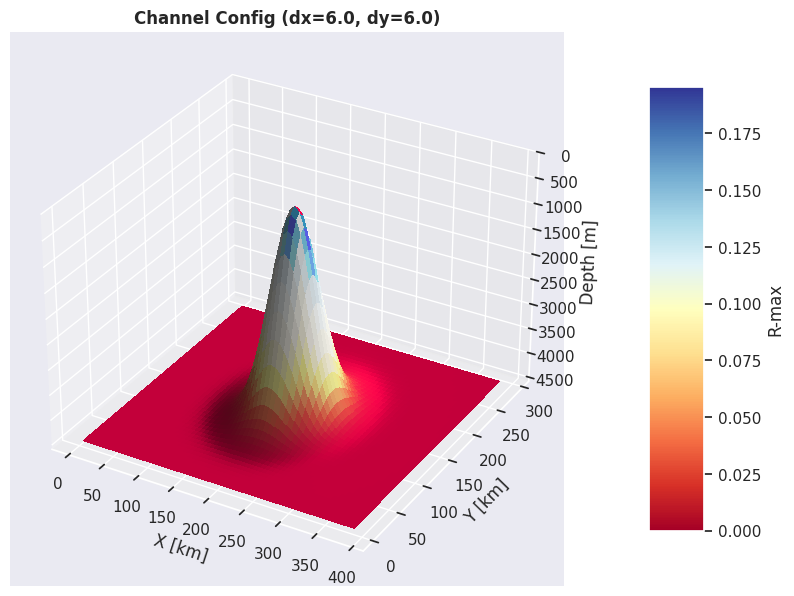

25.5 <class 'numpy.float64'>
5 <class 'numpy.int32'>


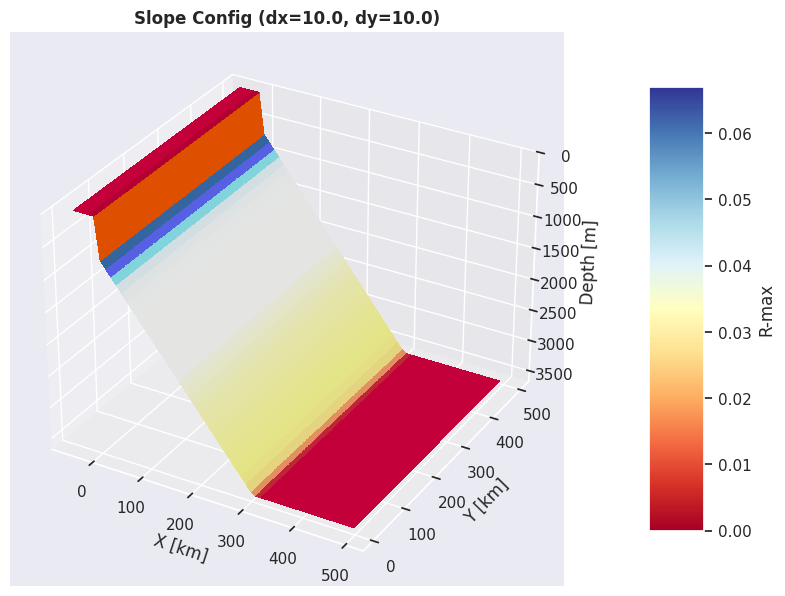

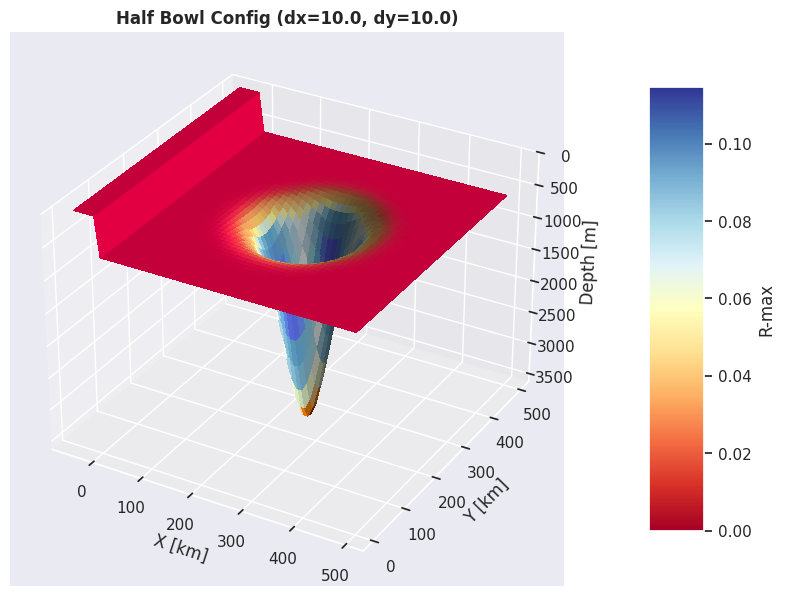

25.5 <class 'numpy.float64'>
5 <class 'numpy.int32'>


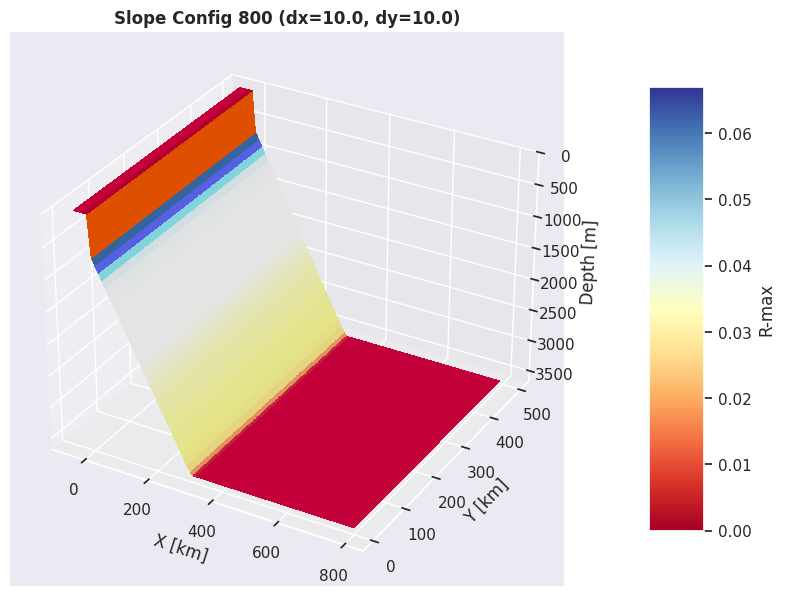

In [26]:
# Plot example configurations
x, y, zt, rm = channel()
plot_dom(x, y, zt, rm, 'Channel Config')
x, y, zt, rm = slope()
plot_dom(x, y, zt, rm, 'Slope Config')
x, y, zt, rm = half_bowl(stiff=2)
plot_dom(x, y, zt, rm, 'Half Bowl Config')
x, y, zt, rm = slope(lx=800)
plot_dom(x, y, zt, rm, 'Slope Config 800')

In [39]:
rm.shape

(50, 85)